### ACL-ATC Data Set
6 CLASSES
0-background
1-compare and contrast
2-extension
3-future
4-motivation
5-uses

### Preparation Steps

In [3]:
!pip install jsonlines
!pip install transformers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import jsonlines
import shutil

from string import punctuation
import string
import numpy as np

import os, os.path
import pandas as pd

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from os.path import join
from absl import flags
import os
import sys
import csv
import collections
import numpy as np
import time
import math
import json
import random
from copy import copy
from collections import defaultdict as dd

import absl.logging as _logging  # pylint: disable=unused-import
import tensorflow as tf

#import sentencepiece as spm

import argparse

import tensorflow as tf
import numpy as np

from transformers import pipeline

import json

### Check GPU Connections

In [1]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan  3 15:36:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Prepare Dataset

In [4]:
# Edit the csv dataset to put the string labels instead of the numeric labels.
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'train.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)


     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

In [6]:
# Create a mapping dictionary for integer to string labels
label_mapping = {0: 'background', 1: 'compare', 2: 'extension', 3: 'future', 4: 'motivation', 5: 'uses'}

# Use the mapping dictionary and the apply function to create the new 'label' column
df_train['label'] = df_train['citation_class_label'].apply(lambda x: label_mapping.get(x, 'Unknown'))

# Display the updated DataFrame
print(df_train)

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

---

### Make Predictions with the facebook/bart-large-mnli model

### Set the inference pipeline

In [7]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["background", "compare", "extension", "future", "motivation", "uses"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df


### Make Predictions

In [8]:
predictions_atl5 = zero_shot(df_train)
print (predictions_atl5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

In [9]:
predictions_atl5.to_csv('inferred_classes_atl5_fb.csv', index=False)

### Set the Prediction Performance Evaluation Function.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_multiclass_classification(y_true, y_pred, class_labels):
    # class_labels should be a list of strings representing your class labels

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision (micro, macro, weighted)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    print(f'Precision (Micro/Macro/Weighted): {precision_micro:.4f} / {precision_macro:.4f} / {precision_weighted:.4f}')

    # Recall (micro, macro, weighted)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    print(f'Recall (Micro/Macro/Weighted): {recall_micro:.4f} / {recall_macro:.4f} / {recall_weighted:.4f}')

    # F1 Score (micro, macro, weighted)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f'F1 Score (Micro/Macro/Weighted): {f1_micro:.4f} / {f1_macro:.4f} / {f1_weighted:.4f}')

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Create a DataFrame for better visualization with class labels
    conf_mat_df = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### Evaluate the Predictions

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

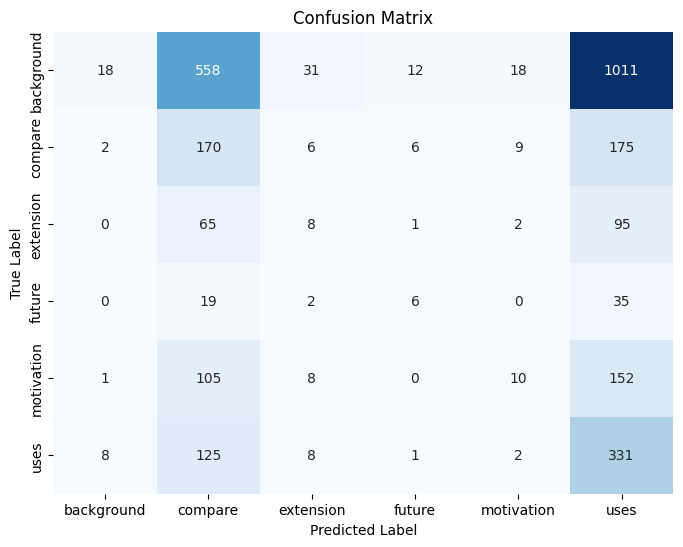

In [13]:
import pandas as pd

# Specify the path to CSV file
csv_file_path = 'inferred_classes_atl5_fb.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["label"], df_train["inferred_label"], ["background", "compare", "extension", "future", "motivation", "uses"])

In [15]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

backgrounduses          1011
backgroundcompare        558
usesuses                 331
compareuses              175
comparecompare           170
motivationuses           152
usescompare              125
motivationcompare        105
extensionuses             95
extensioncompare          65
futureuses                35
backgroundextension       31
futurecompare             19
backgroundmotivation      18
backgroundbackground      18
backgroundfuture          12
motivationmotivation      10
comparemotivation          9
extensionextension         8
usesextension              8
motivationextension        8
usesbackground             8
comparefuture              6
compareextension           6
futurefuture               6
extensionmotivation        2
usesmotivation             2
futureextension            2
comparebackground          2
usesfuture                 1
extensionfuture            1
motivationbackground       1
Name: check, dtype: int64


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_train["label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["label"], df_train["inferred_label"], average=None)

class_labels = ["background", "compare", "extension", "future", "motivation", "uses"]
# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (background): Precision=0.6207, Recall=0.0109, F1-Score=0.0215
Class 1 (compare): Precision=0.1631, Recall=0.4620, F1-Score=0.2411
Class 2 (extension): Precision=0.1270, Recall=0.0468, F1-Score=0.0684
Class 3 (future): Precision=0.2308, Recall=0.0968, F1-Score=0.1364
Class 4 (motivation): Precision=0.2439, Recall=0.0362, F1-Score=0.0631
Class 5 (uses): Precision=0.1840, Recall=0.6968, F1-Score=0.2911


---
---

### Make predictions with the knowledgator/comprehend_it-base model.

### Set the Inference Pipeline

In [18]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="knowledgator/comprehend_it-base", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["background", "compare", "extension", "future", "motivation", "uses"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df

### Make Predictions

In [19]:
predictions_atl5 = zero_shot(df_train)
predictions_atl5.to_csv('inferred_classes_atl5_know.csv', index=False)
#print (predictions_atl5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


### Evaluate the Predictions

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

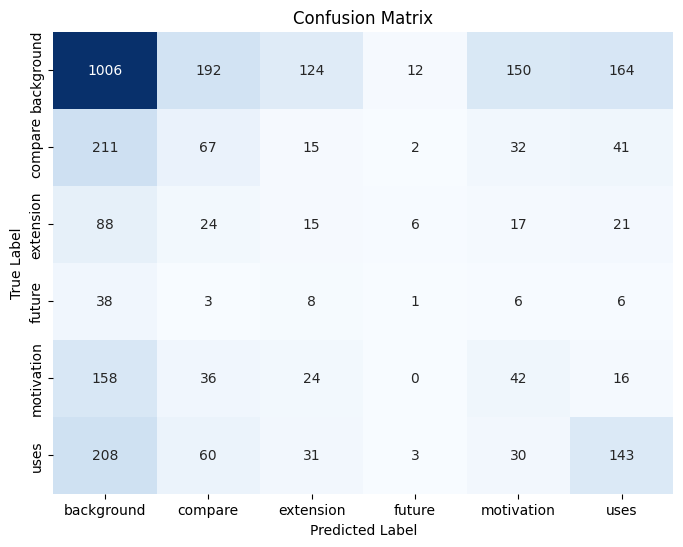

In [20]:
import pandas as pd

# Specify the path to CSV file
csv_file_path = 'inferred_classes_atl5_know.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["label"], df_train["inferred_label"], ["background", "compare", "extension", "future", "motivation", "uses"])

In [21]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

backgroundbackground    1006
comparebackground        211
usesbackground           208
backgroundcompare        192
backgrounduses           164
motivationbackground     158
backgroundmotivation     150
usesuses                 143
backgroundextension      124
extensionbackground       88
comparecompare            67
usescompare               60
motivationmotivation      42
compareuses               41
futurebackground          38
motivationcompare         36
comparemotivation         32
usesextension             31
usesmotivation            30
extensioncompare          24
motivationextension       24
extensionuses             21
extensionmotivation       17
motivationuses            16
extensionextension        15
compareextension          15
backgroundfuture          12
futureextension            8
futuremotivation           6
futureuses                 6
extensionfuture            6
usesfuture                 3
futurecompare              3
comparefuture              2
futurefuture  

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_true and y_pred are your true and predicted labels
precision_per_class = precision_score(df_train["label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["label"], df_train["inferred_label"], average=None)

class_labels = ["background", "compare", "extension", "future", "motivation", "uses"]

# Assuming class_labels is the correct order for your classes
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (background): Precision=0.5886, Recall=0.6104, F1-Score=0.5993
Class 1 (compare): Precision=0.1754, Recall=0.1821, F1-Score=0.1787
Class 2 (extension): Precision=0.0691, Recall=0.0877, F1-Score=0.0773
Class 3 (future): Precision=0.0417, Recall=0.0161, F1-Score=0.0233
Class 4 (motivation): Precision=0.1516, Recall=0.1522, F1-Score=0.1519
Class 5 (uses): Precision=0.3657, Recall=0.3011, F1-Score=0.3303


---
---

### Make predictions with the MoritzLaurer/mDeBERTa-v3-base-mnli-xnli model

### Set the inference Pipeline

In [23]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["background", "compare", "extension", "future", "motivation", "uses"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df

### Make Predictions

In [24]:
predictions_atl5 = zero_shot(df_train)
predictions_atl5.to_csv('inferred_classes_atl5_mdeberta.csv', index=False)
#print (predictions_atl5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


### Evaluate Predictions 

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

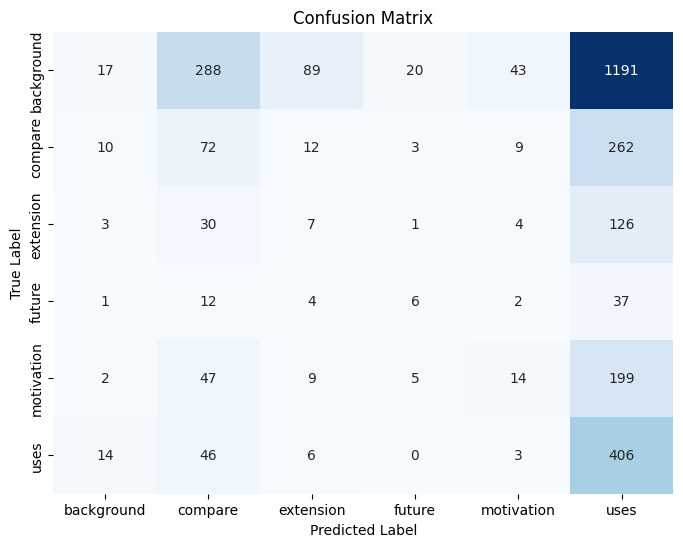

In [25]:
import pandas as pd

# Specify the path to CSV file
csv_file_path = 'inferred_classes_atl5_mdeberta.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["label"], df_train["inferred_label"], ["background", "compare", "extension", "future", "motivation", "uses"])

In [26]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

backgrounduses          1191
usesuses                 406
backgroundcompare        288
compareuses              262
motivationuses           199
extensionuses            126
backgroundextension       89
comparecompare            72
motivationcompare         47
usescompare               46
backgroundmotivation      43
futureuses                37
extensioncompare          30
backgroundfuture          20
backgroundbackground      17
usesbackground            14
motivationmotivation      14
compareextension          12
futurecompare             12
comparebackground         10
comparemotivation          9
motivationextension        9
extensionextension         7
futurefuture               6
usesextension              6
motivationfuture           5
extensionmotivation        4
futureextension            4
comparefuture              3
usesmotivation             3
extensionbackground        3
futuremotivation           2
motivationbackground       2
futurebackground           1
extensionfutur

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_train["label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["label"], df_train["inferred_label"], average=None)

class_labels = ["background", "compare", "extension", "future", "motivation", "uses"]

# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (background): Precision=0.3617, Recall=0.0103, F1-Score=0.0201
Class 1 (compare): Precision=0.1455, Recall=0.1957, F1-Score=0.1669
Class 2 (extension): Precision=0.0551, Recall=0.0409, F1-Score=0.0470
Class 3 (future): Precision=0.1714, Recall=0.0968, F1-Score=0.1237
Class 4 (motivation): Precision=0.1867, Recall=0.0507, F1-Score=0.0798
Class 5 (uses): Precision=0.1828, Recall=0.8547, F1-Score=0.3012


---
---

### Make predictions with the cross-encoder/nli-distilroberta-base model.

### Set the Inference Pipeline.

In [28]:
from transformers import pipeline
import pandas as pd

# Function to perform zero-shot classification and add the inferred classes column
# The input of the function is a DataFrame
def zero_shot(df):

    # Initialize an empty list
    inferences = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="cross-encoder/nli-distilroberta-base", device=0)

    for t in df["citation_context"]:

        # Perform zero-shot classification
        result = classifier(t, candidate_labels=["background", "compare", "extension", "future", "motivation", "uses"])

        # Initialize variables to store the maximum score and its position
        max_score = float('-inf')  # Start with negative infinity to ensure any score will be greater
        max_position = -1

        # Iterate through the scores list
        for i, score in enumerate(result['scores']):
            if score > max_score:
                max_score = score
                max_position = i

        # Add the label with the highest prediction score
        inferences.append(result['labels'][max_position])

    # Add the list to the initial DataFrame
    df['inferred_label'] = inferences

    return df

### Make Predictions

In [29]:
predictions_atl5 = zero_shot(df_train)
predictions_atl5.to_csv('inferred_classes_atl5_distil.csv', index=False)
#print (predictions_atl5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


### Evaluate Predictions

     unique_id     core_id                                       citing_title  \
0          CC1   158977742  Ontology-Based Recommendation of Editorial Pro...   
1          CC2   158977742  Ontology-Based Recommendation of Editorial Pro...   
2          CC3   158977742  Ontology-Based Recommendation of Editorial Pro...   
3          CC4   158977742  Ontology-Based Recommendation of Editorial Pro...   
4          CC5   158977742  Ontology-Based Recommendation of Editorial Pro...   
...        ...         ...                                                ...   
2995    CC2996    81153632  Two steps back, one step forward: reconstructi...   
2996    CC2997    81153632  Two steps back, one step forward: reconstructi...   
2997    CC2998    81153632  Two steps back, one step forward: reconstructi...   
2998    CC2999    81153632  Two steps back, one step forward: reconstructi...   
2999    CC3000  2791771689  Towards Sustainable Self-Compacting Concrete: ...   

                 citing_aut

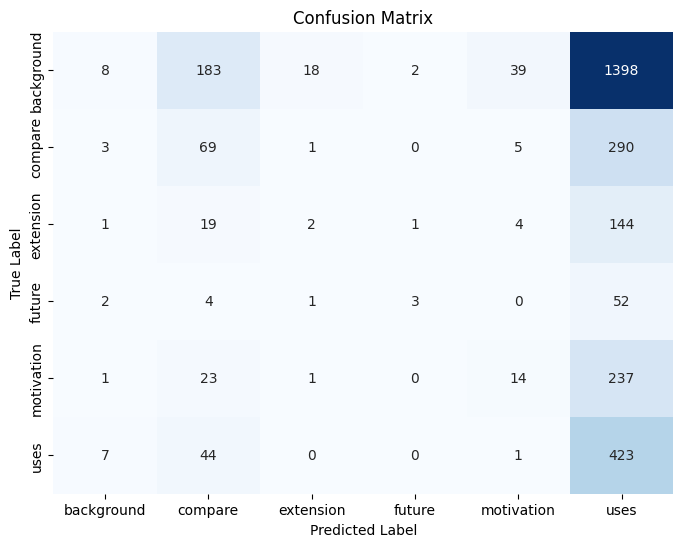

In [30]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'inferred_classes_atl5_distil.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["label"], df_train["inferred_label"], ["background", "compare", "extension", "future", "motivation", "uses"])

In [31]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["label"] + df_train["inferred_label"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

backgrounduses          1398
usesuses                 423
compareuses              290
motivationuses           237
backgroundcompare        183
extensionuses            144
comparecompare            69
futureuses                52
usescompare               44
backgroundmotivation      39
motivationcompare         23
extensioncompare          19
backgroundextension       18
motivationmotivation      14
backgroundbackground       8
usesbackground             7
comparemotivation          5
extensionmotivation        4
futurecompare              4
comparebackground          3
futurefuture               3
backgroundfuture           2
futurebackground           2
extensionextension         2
futureextension            1
usesmotivation             1
motivationextension        1
extensionbackground        1
compareextension           1
extensionfuture            1
motivationbackground       1
Name: check, dtype: int64


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_train["label"], df_train["inferred_label"], average=None)
recall_per_class = recall_score(df_train["label"], df_train["inferred_label"], average=None)
f1_per_class = f1_score(df_train["label"], df_train["inferred_label"], average=None)

class_labels = ["background", "compare", "extension", "future", "motivation", "uses"]

# Print the calculation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (background): Precision=0.3636, Recall=0.0049, F1-Score=0.0096
Class 1 (compare): Precision=0.2018, Recall=0.1875, F1-Score=0.1944
Class 2 (extension): Precision=0.0870, Recall=0.0117, F1-Score=0.0206
Class 3 (future): Precision=0.5000, Recall=0.0484, F1-Score=0.0882
Class 4 (motivation): Precision=0.2222, Recall=0.0507, F1-Score=0.0826
Class 5 (uses): Precision=0.1663, Recall=0.8905, F1-Score=0.2802
